In this notebook I will go through the step to combine BPASS data (SNe & GW event rates for a specific population) with data from the Millenium simulation, specifically the star formation rate. 
In this example, we will take metallicity into account and is therefore a little more complex than the `Event_Rates_noZ.ipynb`. We will skip some explanations here that can be found there. 


The cosmological simulation has a continuous metallicity, but BPASS is binned. Therefore, we will bin the Stellar Foramation Rate (SFR) in the BPASS bins.

In [3]:
import kea.load 
import kea.hist
import kea.rates
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import interpolate
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})
%matplotlib inline


In [12]:
metallicities = ["em5", "em4", "001","002", "003", "004", "006", "008", "010", "014", "020", "030", "040"]
num_Z = [0.00001, 0.0001, 0.001, 0.002, 0.003, 0.004, 0.006, 0.008, 0.010, 0.014, 0.020, 0.030, 0.040]
SNe_types = ["ccsn", "Ia", "LGRB", "PISNe"]
compact_types = ["BHBH", "BHNS", "NSNS"]

data_folder = "../../data/"
output_folder = "../images/"
now = 13.799

# Millenium Simulation

We use the script `calculate2dSFRD` to extract the SFRD over time and metallicity from the Millenium Simulation. 

This script creates a 2D matrix with one side being time and the other the metallicity 
For each snapshot in the Millenium simulation we calculate the stellar mass for each galaxy.
We then find the closest model in BPASS and add it to that bin in the 2D matrix. 


`Example: python calculate2dSFRD.py
                                -i "../../data/large_galaxy.dat"
                                -t "../../data/timerel.dat"
                                -o "../../data/2dSFRD.p"
`


In [13]:
data_file = data_folder+"large_galaxy.dat"
time_file = data_folder+"timerel.dat"
output_file = data_folder+"2dSFRD.p"

### Open pickle 

Instead of running the above script, we can just open the pickles data file. 

In [15]:
tr = pd.read_csv(data_folder+"timerel.dat", comment="#")
SFRD = pickle.load(open(output_file, "rb"))

# 1. Plot the SFRD per metallicity 

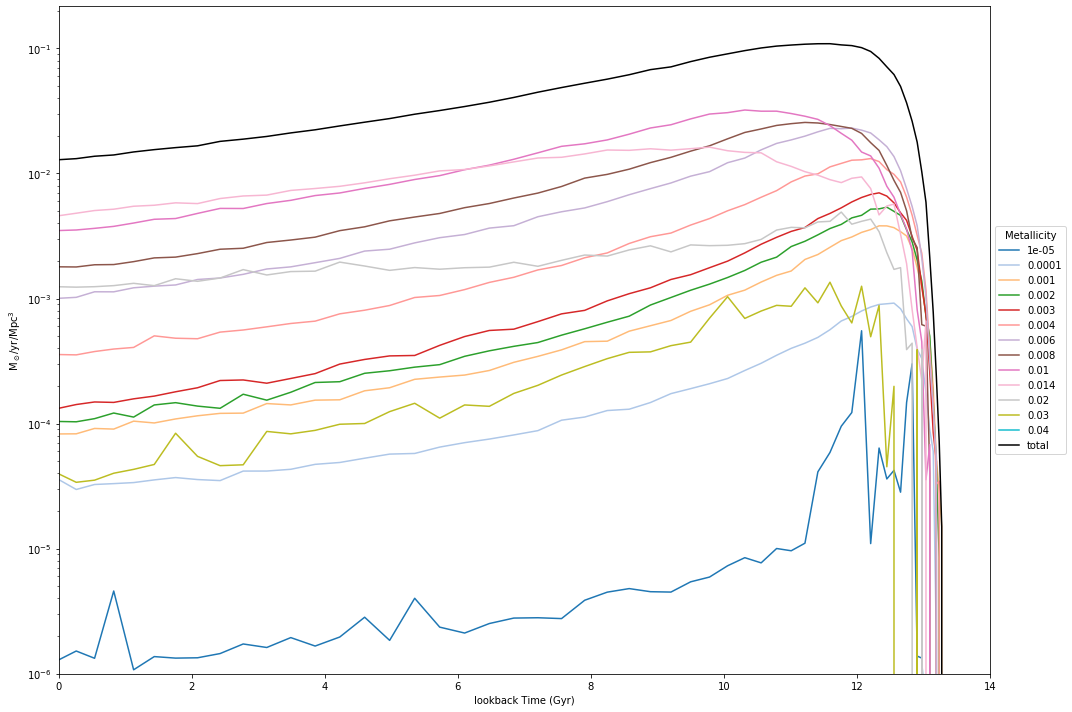

In [16]:
NUM_COLORS=len(SFRD.T)
cm = plt.get_cmap('tab20')
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

total = np.zeros(len(tr["lookbackTime"]))

for column in SFRD:
    plt.plot(tr["lookbackTime"], SFRD[column].values, label=column)
    total += SFRD[column]

plt.plot(tr["lookbackTime"], total, label="total", color="black")
plt.yscale('log')
plt.ylabel("M$_\odot$/yr/Mpc$^3$")
plt.xlabel("lookback Time (Gyr)")
plt.legend(title="Metallicity", loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')
plt.ylim(1e-6)
plt.xlim(0,14)
plt.tight_layout()
plt.savefig(output_folder+"metallicities/SFR.pdf")

## Retrieve BPASS events and calculate the event rate

To calculate the event rate the script `calculate2dEventRates.py` can be used. This calculates and stored the event rate in a 2D pandas DataFrame, such that it does not have to be calculated again. 


`python calculate2dEventRates.py -s "../../data/2dSFRD.p"
                                -t "../../data/timerel.dat"
                                -i "../../data/"
                                -o "../../data/2dEventRates.p"`

## Open the Event Rate pickle

In [17]:
eventRates = pickle.load(open(data_folder+"2dEventRates.p", "rb"))

# 2. Output event rate per metallicity

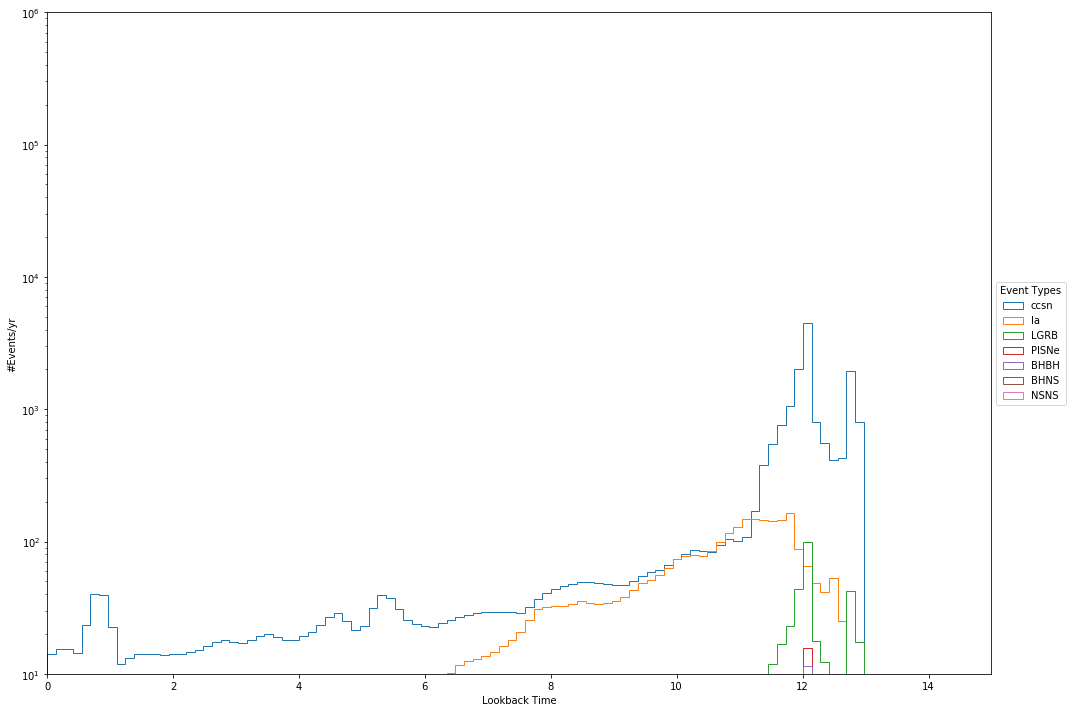

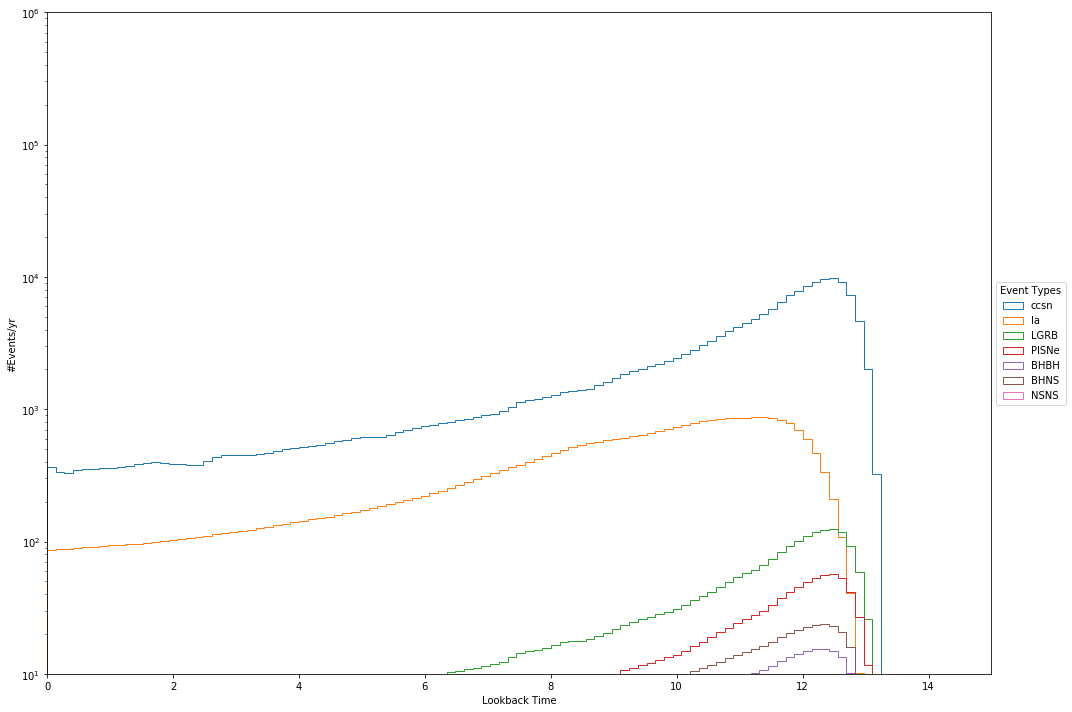

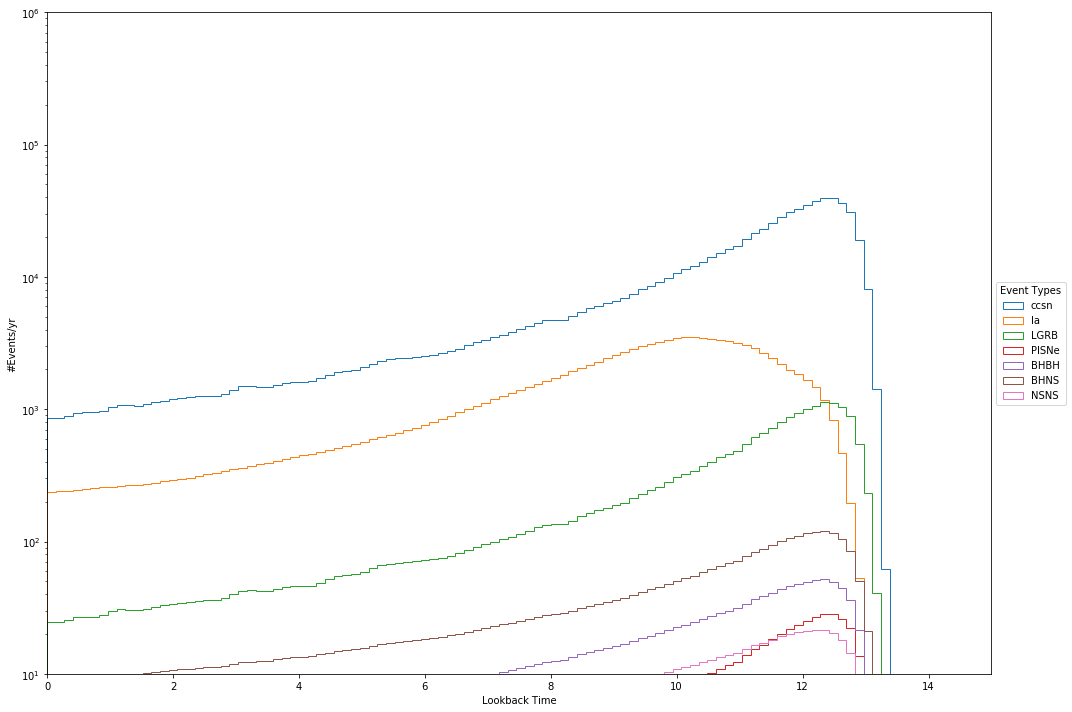

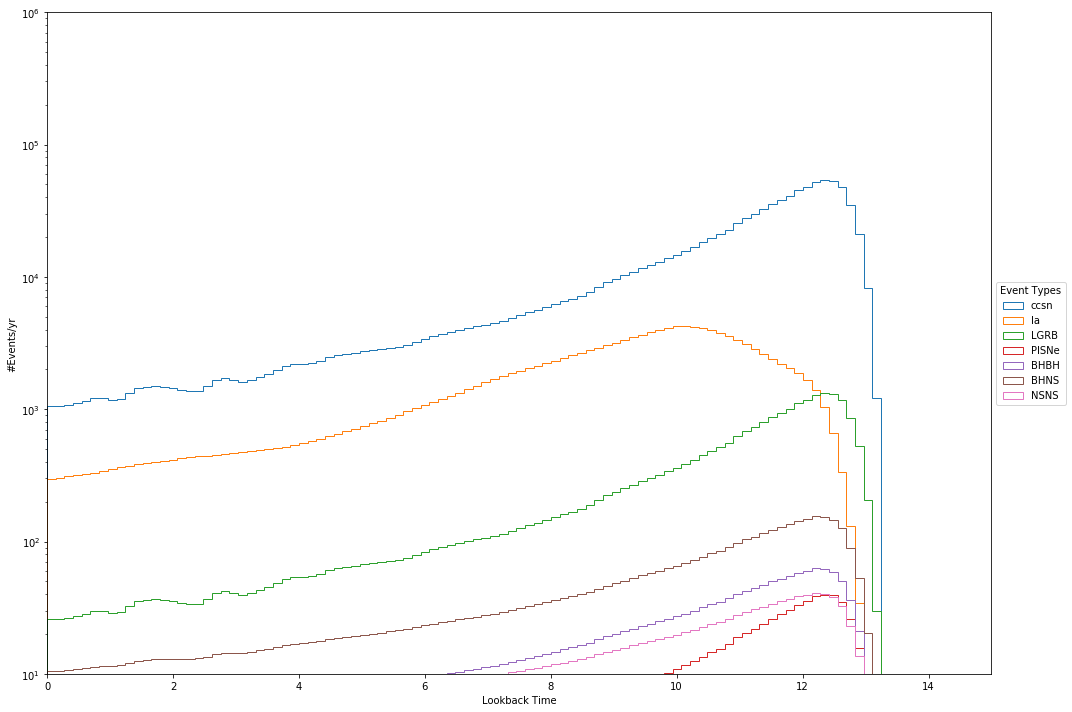

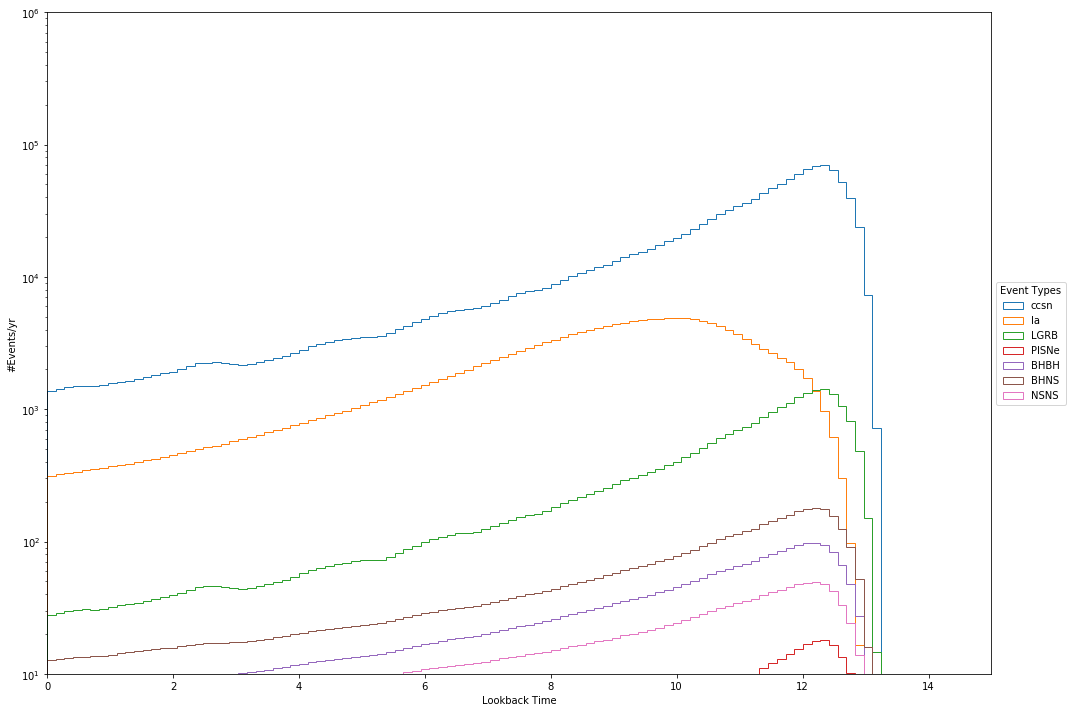

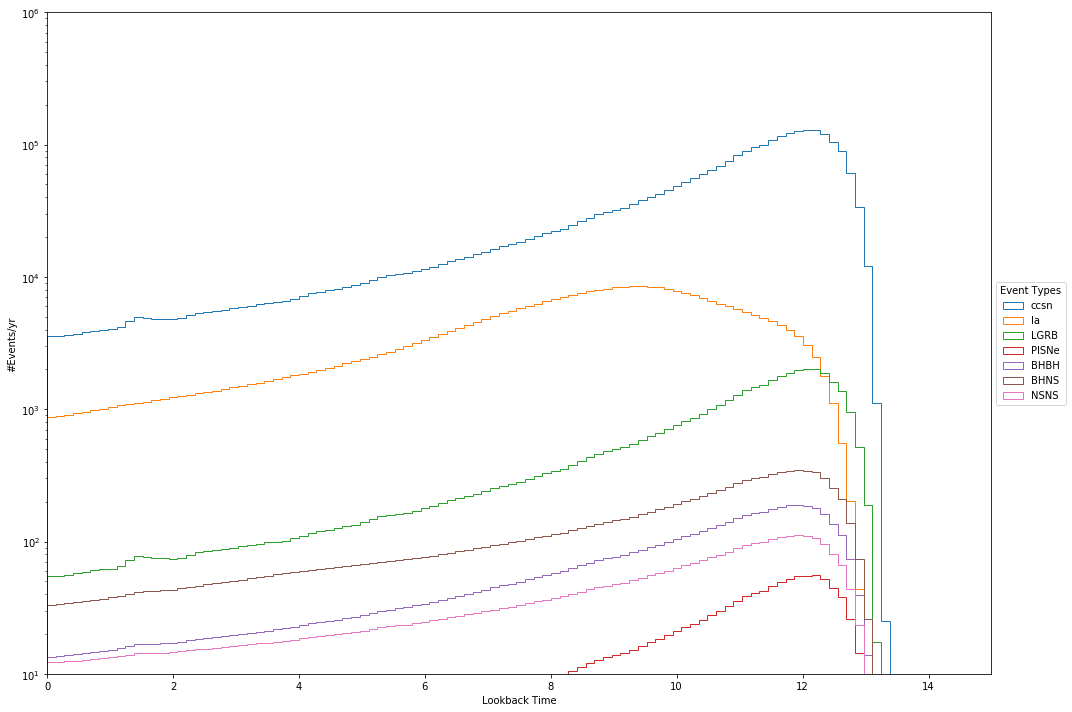

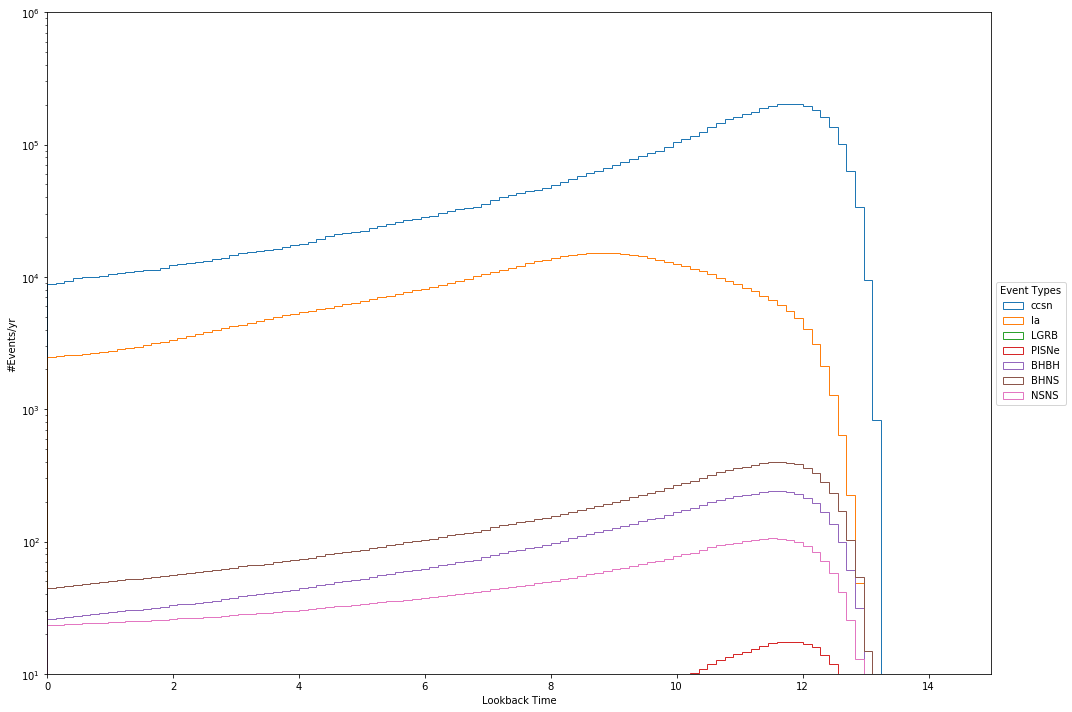

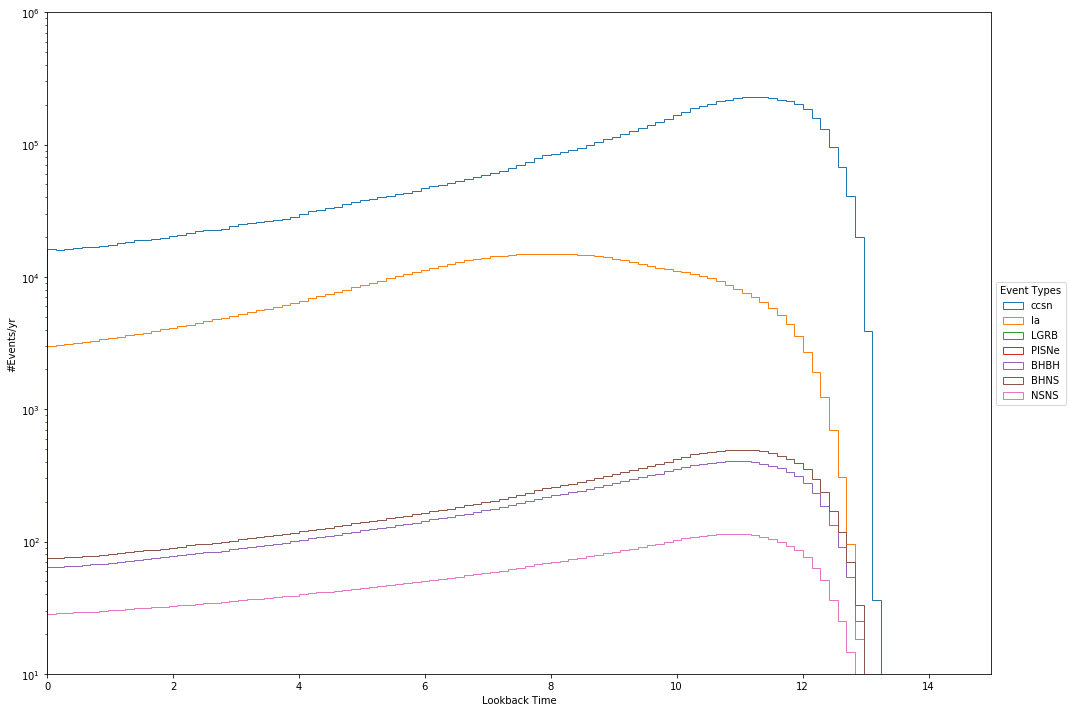

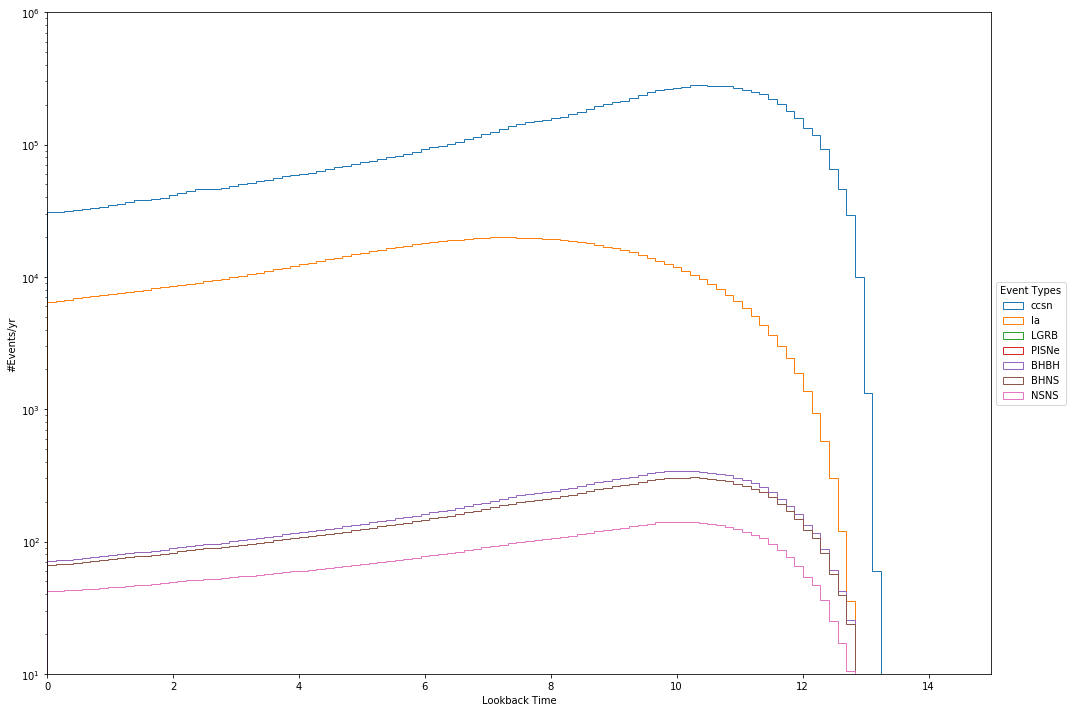

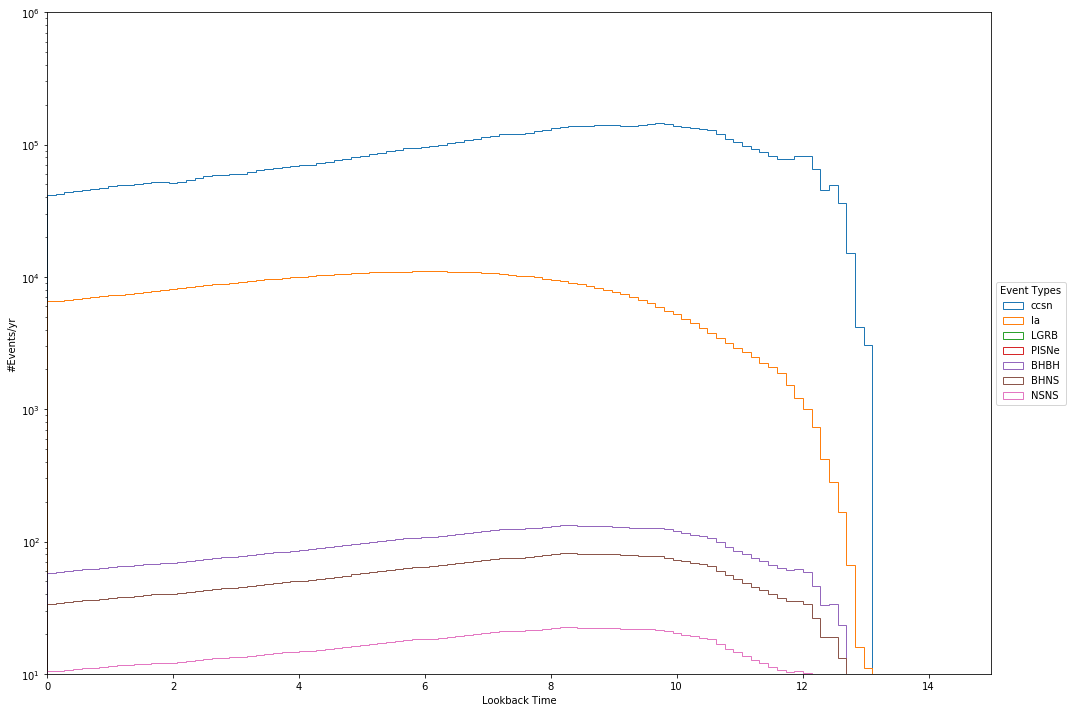

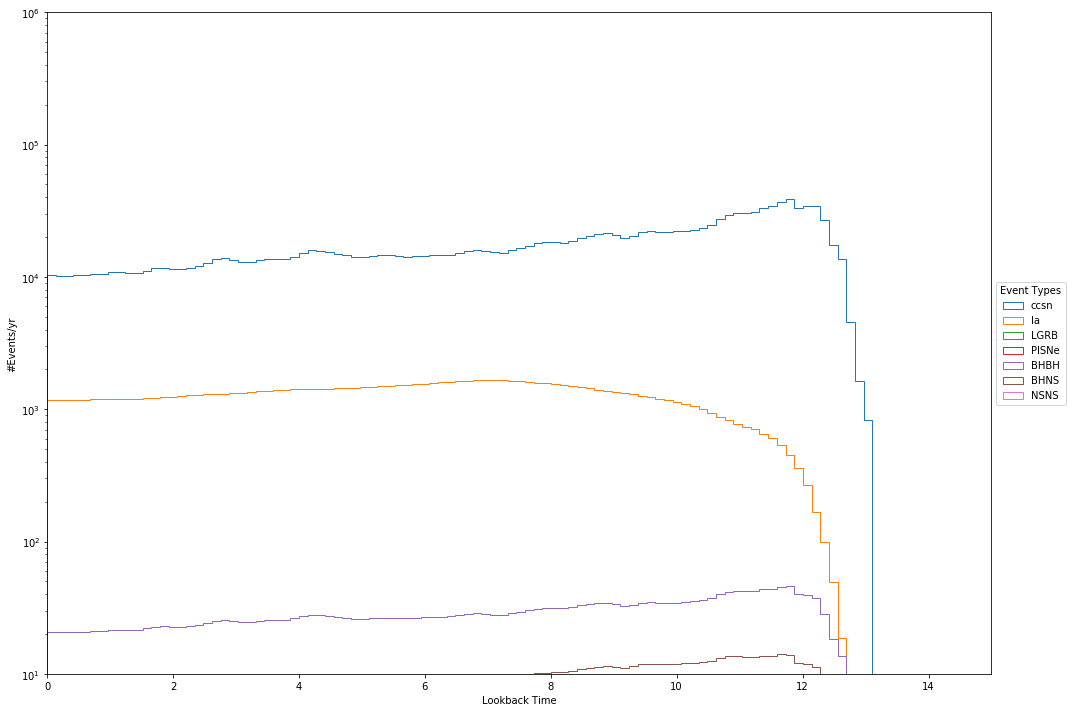

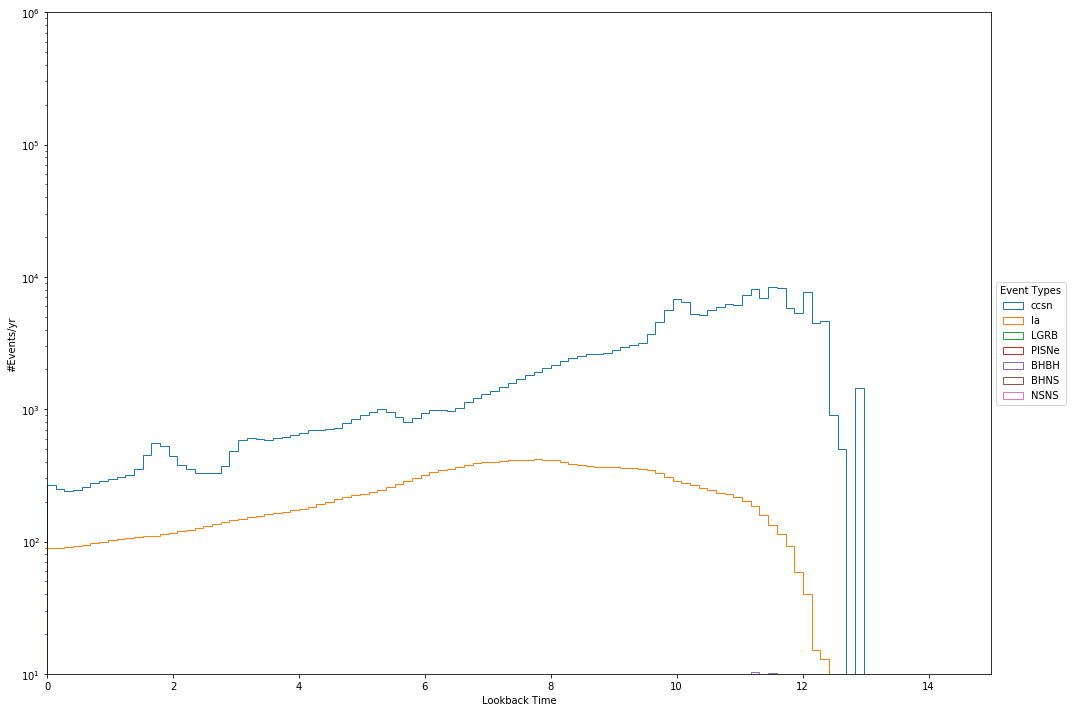

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  


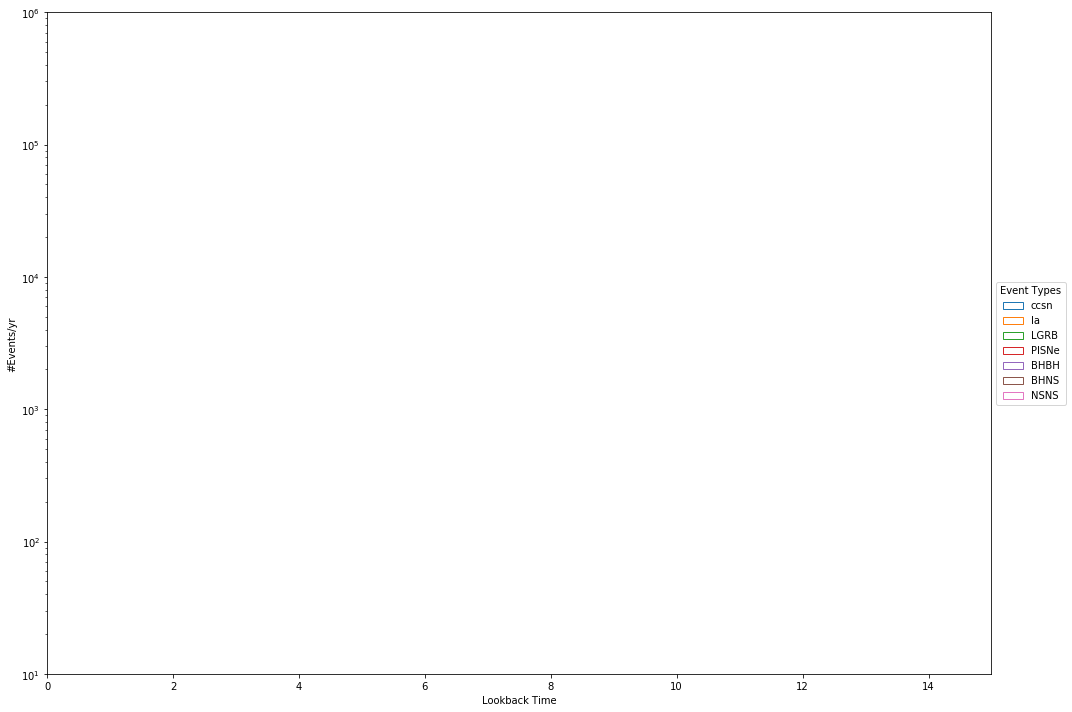

In [18]:
for Z in eventRates:
    plt.figure(figsize=(15,10))
    events = eventRates[Z]
    for i in events:
        events[i].plot(label=i)
    plt.yscale("log")
    plt.xlim(0,15)
    plt.ylim(10, 1e6)
    plt.xlabel("Lookback Time")
    plt.ylabel("#Events/yr")
    plt.legend(title="Event Types", loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.savefig(output_folder+"metallicities/event_rates/Z"+str(Z)+".pdf")

# 3. Plot SFRD  over metallicity and lookback Time

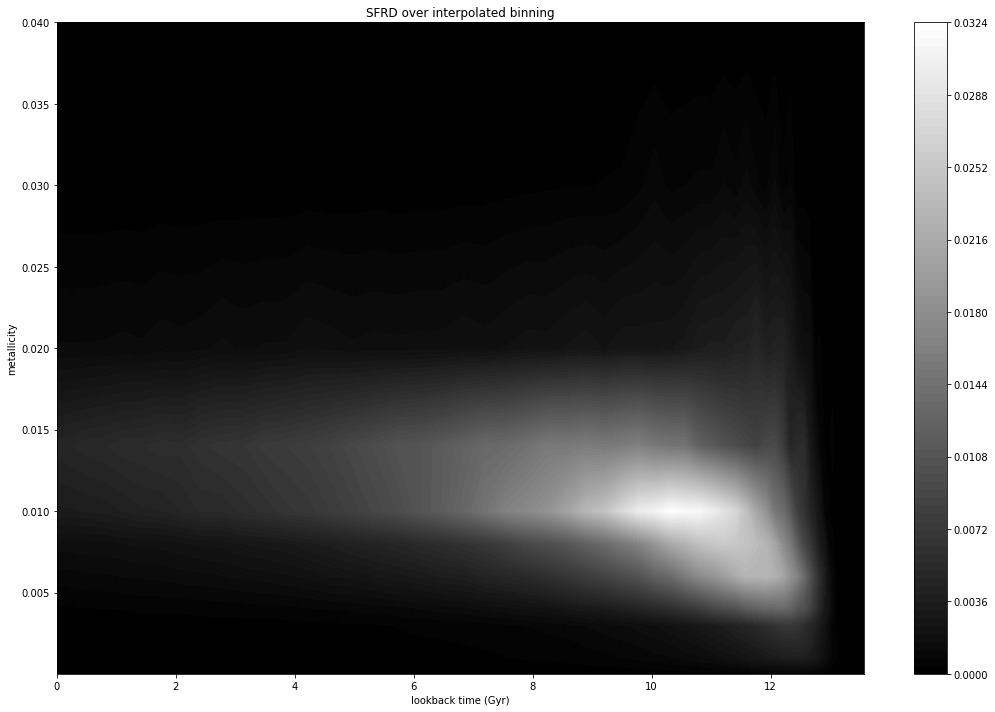

In [20]:
plt.figure(figsize=(15,10))
plt.contourf(tr["lookbackTime"],num_Z,SFRD.T,100, cmap='gist_gray')
plt.colorbar()
plt.xlabel("lookback time (Gyr)")
plt.ylabel("metallicity")
plt.title("SFRD over interpolated binning")
plt.tight_layout()
plt.savefig(output_folder+"/metallicities/2D_SFRFcontour.pdf")

# 4. Plot different metallicities for a single event type over lookback Time

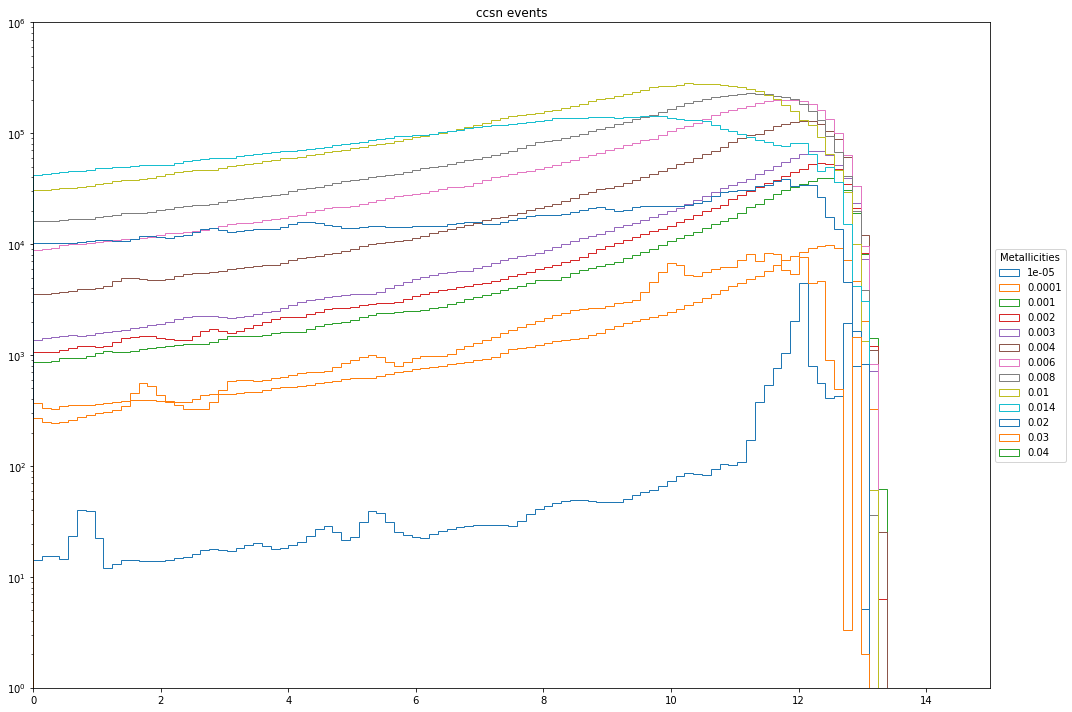

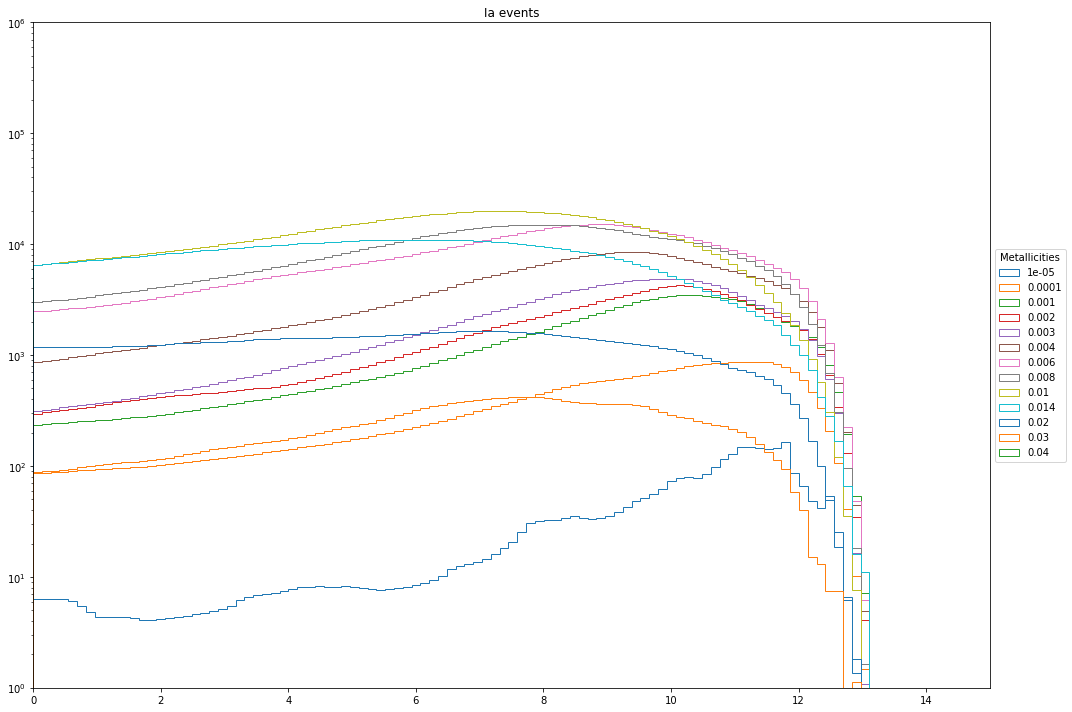

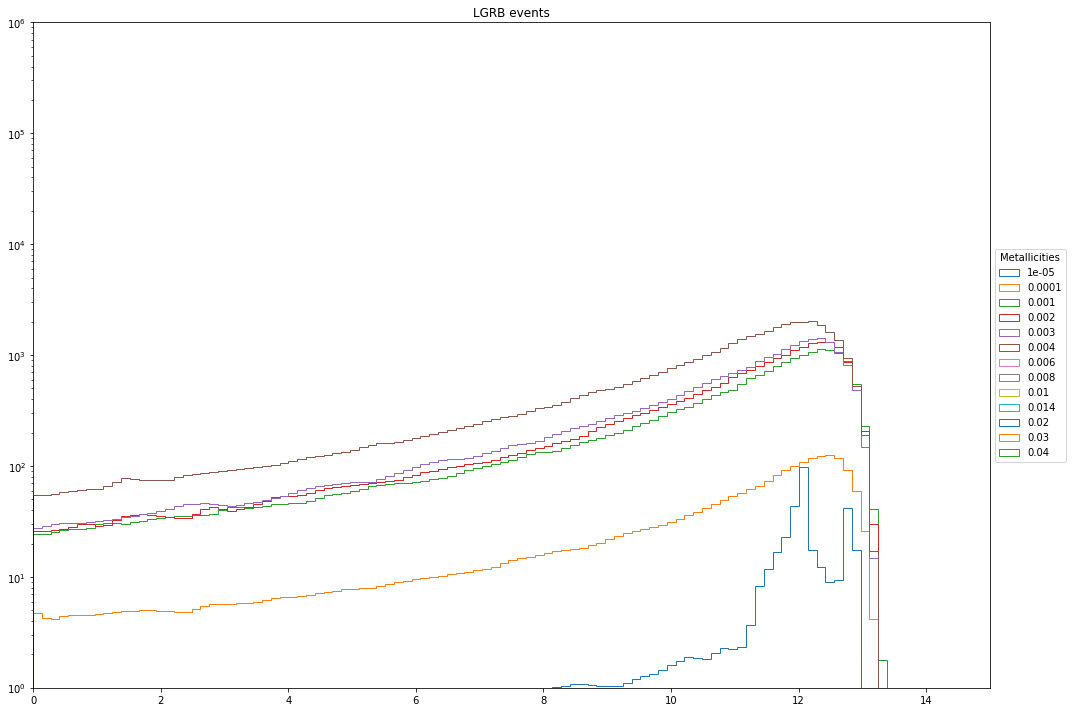

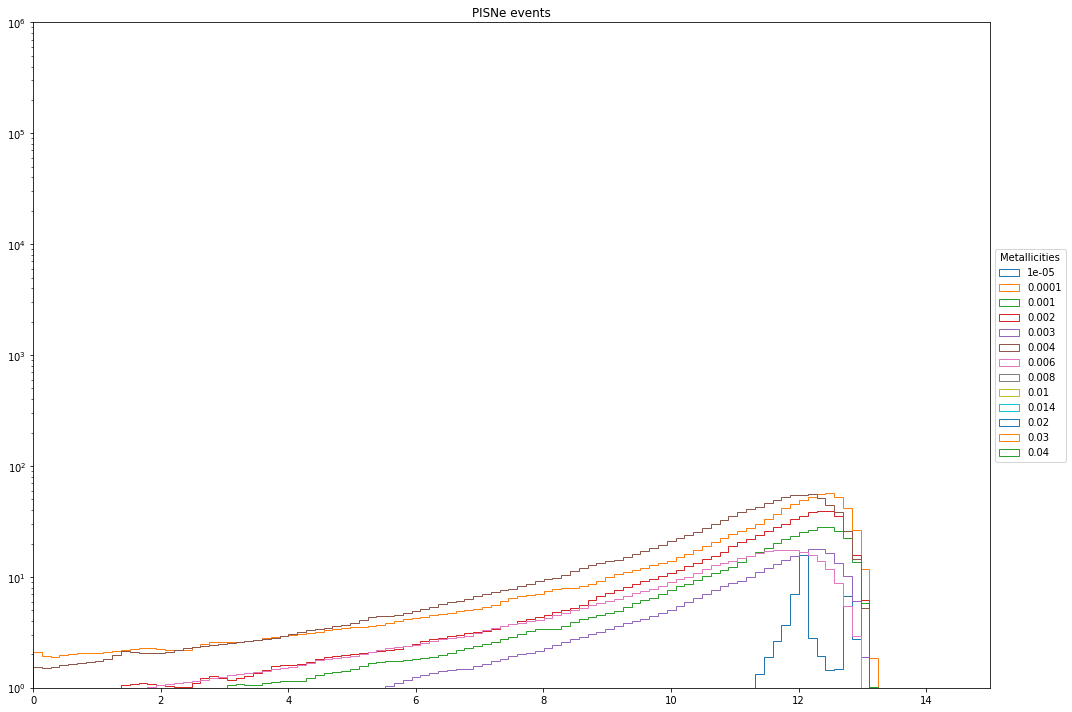

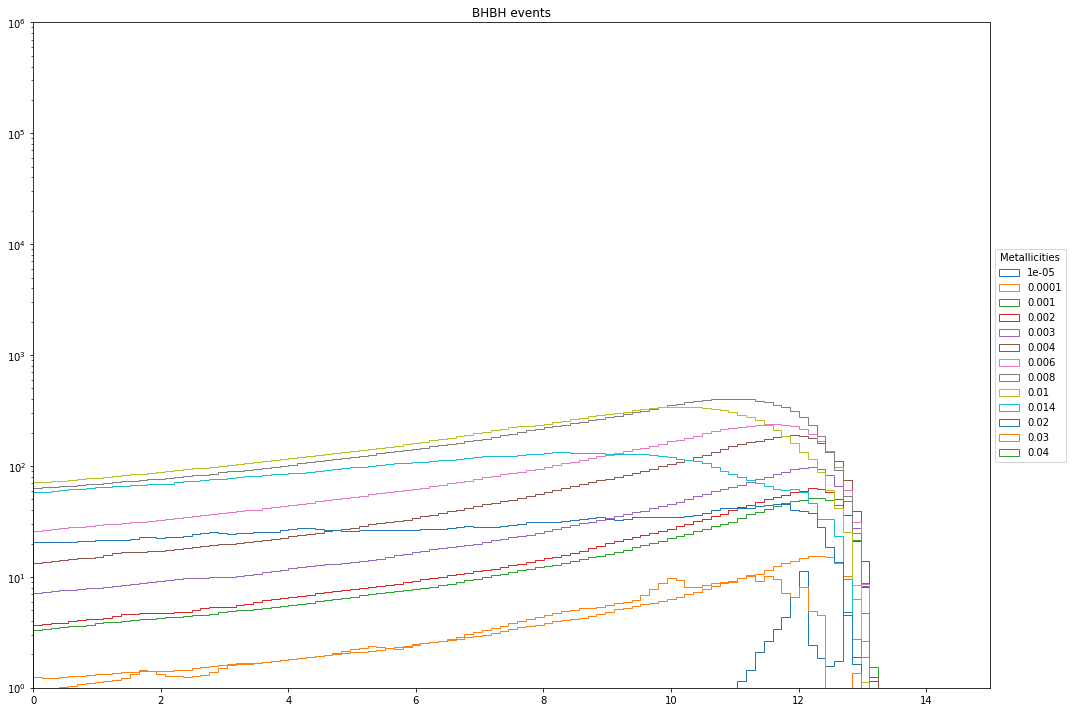

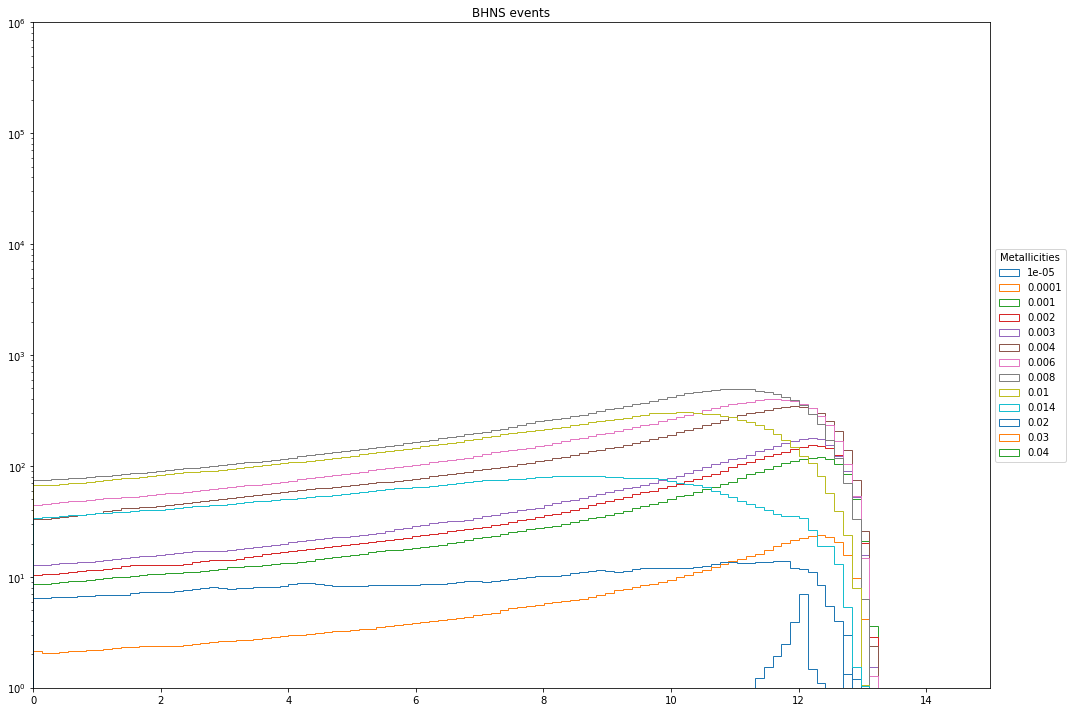

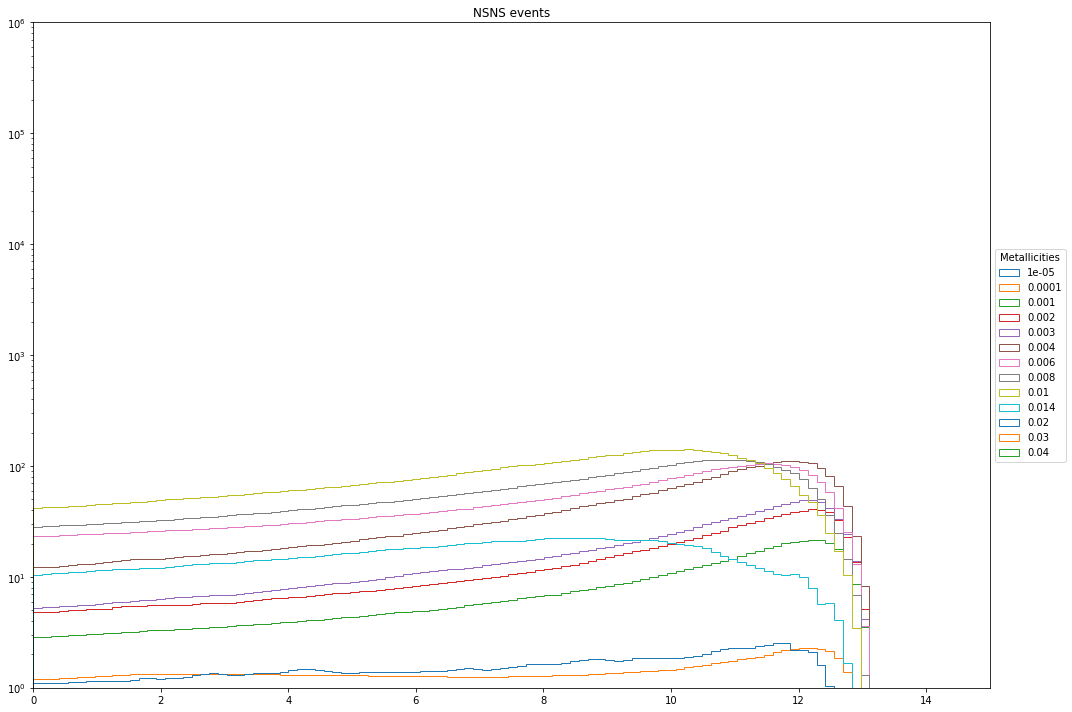

In [21]:
val = list(eventRates.values())[0]# get one histogram element for the event types
for i in val:
    plt.figure(figsize=(15,10))
    for Z in eventRates:
        eventRates[Z][i].plot(label=Z)
        
    plt.title(str(i) + " events")
    plt.legend(title="Metallicities", loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlim(0, 15)
    plt.yscale('log')
    plt.ylim(1e0, 1e6)
    plt.tight_layout()
    plt.savefig(output_folder+"metallicities/event_rates/"+i)

# 5. Combine into a total event rate

In [24]:
total = {i:kea.hist.histogram(0, now, 100) for i in eventRates[0.010]}
bins = total['ccsn'].getBinEdges()
for i in eventRates:
    for j in eventRates[i]:
        total[j].Fill(bins[:-1], eventRates[i][j].getValues())

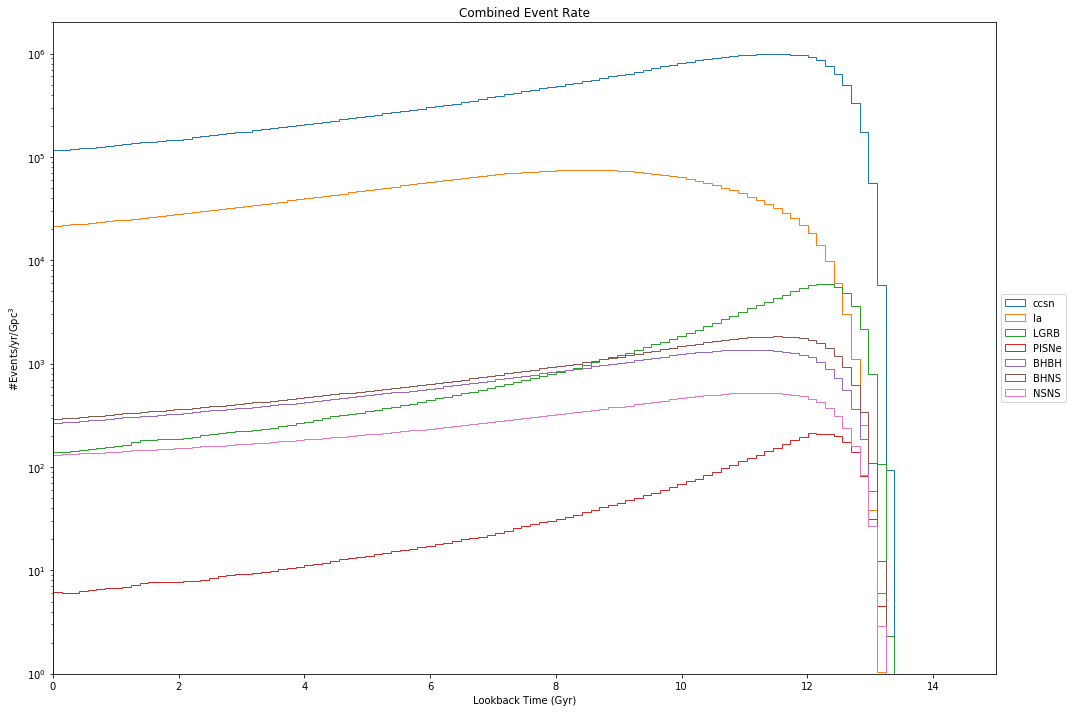

In [25]:
plt.figure(figsize=(15,10))

for i in total:
    total[i].plot(label=i)
    
plt.yscale("log")
plt.xlim(0,15)
plt.ylabel("#Events/yr/Gpc$^3$")
plt.xlabel("Lookback Time (Gyr)")
plt.ylim(1, 2e6)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.title("Combined Event Rate")
plt.tight_layout()
plt.savefig(output_folder+"metallicities/event_rates/Combined.pdf")